# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [114]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [115]:
import numpy as np
import pandas as pd

import seaborn as sns
import math

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings('ignore')

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [165]:
try:
    df = pd.read_csv('/datasets/insurance_us.csv')
except:
    df = pd.read_csv("https://code.s3.yandex.net//datasets/insurance_us.csv")

We rename the colums to make the code look more consistent with its style.

In [117]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [118]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
780,0,24.0,60300.0,0,0
2660,0,36.0,19900.0,1,0
2474,0,21.0,33400.0,3,0
2323,0,22.0,45800.0,1,0
2623,0,28.0,43000.0,0,0
3316,1,18.0,27000.0,1,0
564,0,30.0,39100.0,0,0
292,0,32.0,47200.0,1,0
4896,1,37.0,49200.0,1,0
524,1,22.0,45200.0,1,0


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [120]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:
df['age'] = df['age'].astype(int)
#df['gender'] = df['gender'].astype('bool')
df['income'] = df['income'].astype(int)

In [121]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int64
 1   age                 5000 non-null   int32
 2   income              5000 non-null   int32
 3   family_members      5000 non-null   int64
 4   insurance_benefits  5000 non-null   int64
dtypes: int32(2), int64(3)
memory usage: 156.4 KB


In [122]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.359400,1.194200,0.148000
std,0.500049,8.440807,9900.082063,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

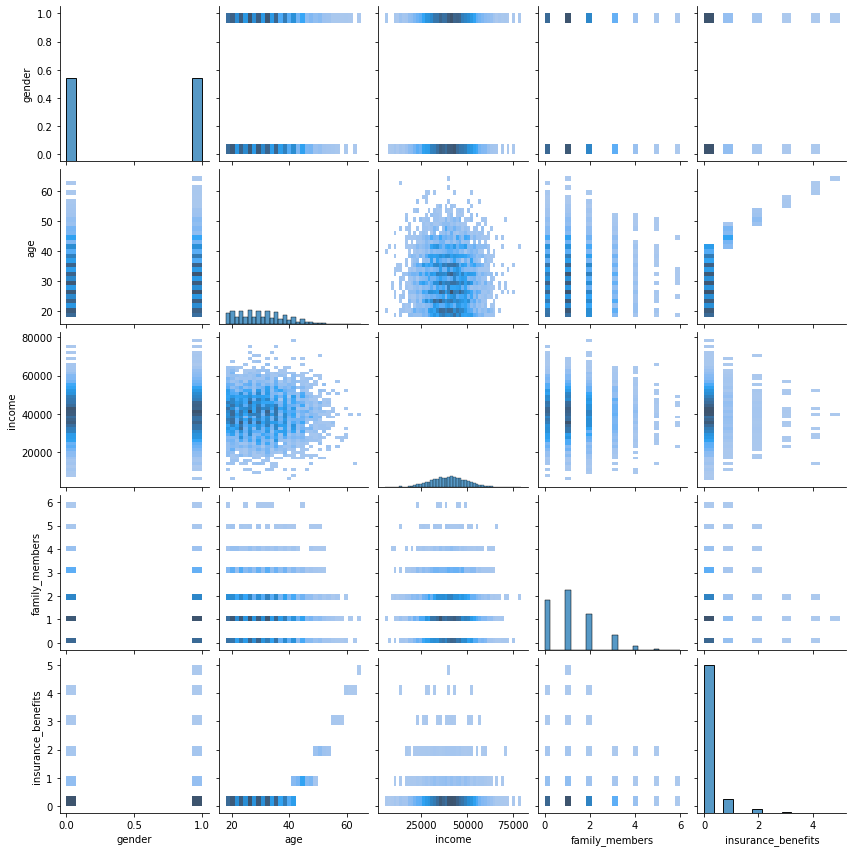

In [123]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [124]:
feature_names = ['gender', 'age', 'income', 'family_members']

When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.

In [125]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    X=df[feature_names].to_numpy().tolist()
    nbrs= NearestNeighbors(p=metric).fit(X)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [126]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [127]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1458,0.0,0.369231,0.674684,0.166667,0
4113,1.0,0.507692,0.529114,0.000000,0
3421,1.0,0.307692,0.649367,0.000000,0
1311,0.0,0.492308,0.686076,0.166667,0
737,1.0,0.415385,0.694937,0.166667,0


Now, let's get similar records for a given one for every combination

**Using Manhattan distance:**

In [128]:
df_res_m=[]
for i in range(len(df)):
    res=get_knn(df, i, 2, 1).reset_index()
    df_res_m.append(res.loc[1])
df_res_m = pd.DataFrame(df_res_m)
df_res_m

,index,gender,age,income,family_members,insurance_benefits,distance
1,2022.0,1.0,41.0,49600.0,0.0,0.0,1.0
1,3920.0,0.0,40.0,38000.0,0.0,0.0,7.0
1,4544.0,1.0,31.0,21000.0,1.0,0.0,4.0
1,3894.0,0.0,21.0,41700.0,2.0,0.0,0.0
1,2701.0,1.0,31.0,26100.0,3.0,0.0,6.0
...,...,...,...,...,...,...,...
1,1437.0,0.0,25.0,35700.0,1.0,0.0,4.0
1,3495.0,1.0,35.0,52400.0,1.0,0.0,2.0
1,2237.0,0.0,19.0,33900.0,0.0,0.0,3.0
1,3466.0,0.0,22.0,32700.0,4.0,0.0,2.0


In [129]:
df_res_scaled_m=[]
for i in range(len(df_scaled)):
    res=get_knn(df_scaled, i, 2, 1).reset_index()
    df_res_scaled_m.append(res.loc[1])
df_res_scaled_m = pd.DataFrame(df_res_scaled_m)
df_res_scaled_m

,index,gender,age,income,family_members,insurance_benefits,distance
1,2689.0,1.0,0.630769,0.634177,0.166667,0.0,0.006329
1,4162.0,0.0,0.707692,0.477215,0.166667,1.0,0.003797
1,509.0,0.0,0.446154,0.255696,0.000000,0.0,0.010127
1,3.0,0.0,0.323077,0.527848,0.333333,0.0,0.000000
1,349.0,1.0,0.430769,0.322785,0.000000,0.0,0.007595
...,...,...,...,...,...,...,...
1,1433.0,0.0,0.430769,0.448101,0.333333,0.0,0.003797
1,1397.0,0.0,0.507692,0.659494,0.166667,0.0,0.019182
1,2085.0,0.0,0.307692,0.430380,0.333333,0.0,0.001266
1,2127.0,1.0,0.323077,0.421519,0.500000,0.0,0.022980


In [130]:
df_res_m.compare(df_res_scaled_m, align_axis=0)

index  gender        age        income  family_members  \
1 self   2022.0     NaN  41.000000  49600.000000        0.000000   
  other  2689.0     NaN   0.630769      0.634177        0.166667   
  self   3920.0     NaN  40.000000  38000.000000        0.000000   
  other  4162.0     NaN   0.707692      0.477215        0.166667   
  self   4544.0     1.0  31.000000  21000.000000        1.000000   
...         ...     ...        ...           ...             ...   
  other  2085.0     NaN   0.307692      0.430380        0.333333   
  self   3466.0     0.0  22.000000  32700.000000        4.000000   
  other  2127.0     1.0   0.323077      0.421519        0.500000   
  self   3512.0     NaN  27.000000  40600.000000        1.000000   
  other  4989.0     NaN   0.430769      0.517722        0.166667   

         insurance_benefits  distance  
1 self                  NaN  1.000000  
  other                 NaN  0.006329  
  self                  0.0  7.000000  
  other                 1.0  0.003797  
  self                  NaN  4.000000  
...                     ...       ...  
  other                 NaN  0.001266  
  self                  NaN  2.000000  
  other                 NaN  0.022980  
  self                  NaN  1.000000  
  other                 NaN  0.003797  

[10000 rows x 7 columns]

**Using Euclidean distance:**

In [131]:
df_res_e=[]
for i in range(len(df)):
    res=get_knn(df, i, 2, 2).reset_index()
    df_res_e.append(res.loc[1])
df_res_e = pd.DataFrame(df_res_e)
df_res_e

,index,gender,age,income,family_members,insurance_benefits,distance
1,2022.0,1.0,41.0,49600.0,0.0,0.0,1.000000
1,3920.0,0.0,40.0,38000.0,0.0,0.0,6.082763
1,4544.0,1.0,31.0,21000.0,1.0,0.0,2.449490
1,3894.0,0.0,21.0,41700.0,2.0,0.0,0.000000
1,2701.0,1.0,31.0,26100.0,3.0,0.0,4.242641
...,...,...,...,...,...,...,...
1,4488.0,1.0,30.0,35700.0,0.0,0.0,3.000000
1,3495.0,1.0,35.0,52400.0,1.0,0.0,1.414214
1,3887.0,1.0,19.0,33900.0,1.0,0.0,1.732051
1,3466.0,0.0,22.0,32700.0,4.0,0.0,1.414214


In [132]:
df_res_scaled_e=[]
for i in range(len(df_scaled)):
    res=get_knn(df_scaled, i, 2, 2).reset_index()
    df_res_scaled_e.append(res.loc[1])
df_res_scaled_e = pd.DataFrame(df_res_scaled_e)
df_res_scaled_e

,index,gender,age,income,family_members,insurance_benefits,distance
1,2689.0,1.0,0.630769,0.634177,0.166667,0.0,0.006329
1,4162.0,0.0,0.707692,0.477215,0.166667,1.0,0.003797
1,509.0,0.0,0.446154,0.255696,0.000000,0.0,0.010127
1,3.0,0.0,0.323077,0.527848,0.333333,0.0,0.000000
1,349.0,1.0,0.430769,0.322785,0.000000,0.0,0.007595
...,...,...,...,...,...,...,...
1,1433.0,0.0,0.430769,0.448101,0.333333,0.0,0.003797
1,1397.0,0.0,0.507692,0.659494,0.166667,0.0,0.015846
1,2085.0,0.0,0.307692,0.430380,0.333333,0.0,0.001266
1,2127.0,1.0,0.323077,0.421519,0.500000,0.0,0.017157


In [133]:
df_res_e.compare(df_res_scaled_e, align_axis=0)

index  gender        age        income  family_members  \
1 self   2022.0     NaN  41.000000  49600.000000        0.000000   
  other  2689.0     NaN   0.630769      0.634177        0.166667   
  self   3920.0     NaN  40.000000  38000.000000        0.000000   
  other  4162.0     NaN   0.707692      0.477215        0.166667   
  self   4544.0     1.0  31.000000  21000.000000        1.000000   
...         ...     ...        ...           ...             ...   
  other  2085.0     0.0   0.307692      0.430380        0.333333   
  self   3466.0     0.0  22.000000  32700.000000        4.000000   
  other  2127.0     1.0   0.323077      0.421519        0.500000   
  self   3512.0     NaN  27.000000  40600.000000        1.000000   
  other  4989.0     NaN   0.430769      0.517722        0.166667   

         insurance_benefits  distance  
1 self                  NaN  1.000000  
  other                 NaN  0.006329  
  self                  0.0  6.082763  
  other                 1.0  0.003797  
  self                  NaN  2.449490  
...                     ...       ...  
  other                 NaN  0.001266  
  self                  NaN  1.414214  
  other                 NaN  0.017157  
  self                  NaN  1.000000  
  other                 NaN  0.003797  

[10000 rows x 7 columns]

In [134]:
df_res_m.compare(df_res_e, align_axis=0)

index  gender  age  income  family_members  insurance_benefits  \
1 self      NaN     NaN  NaN     NaN             NaN                 NaN   
  other     NaN     NaN  NaN     NaN             NaN                 NaN   
  self      NaN     NaN  NaN     NaN             NaN                 NaN   
  other     NaN     NaN  NaN     NaN             NaN                 NaN   
  self      NaN     NaN  NaN     NaN             NaN                 NaN   
...         ...     ...  ...     ...             ...                 ...   
  other     NaN     NaN  NaN     NaN             NaN                 NaN   
  self   2237.0     0.0  NaN     NaN             0.0                 NaN   
  other  3887.0     1.0  NaN     NaN             1.0                 NaN   
  self      NaN     NaN  NaN     NaN             NaN                 NaN   
  other     NaN     NaN  NaN     NaN             NaN                 NaN   

         distance  
1 self   7.000000  
  other  6.082763  
  self   4.000000  
  other  2.449490  
  self   6.000000  
...           ...  
  other  1.414214  
  self   3.000000  
  other  1.732051  
  self   2.000000  
  other  1.414214  

[6274 rows x 7 columns]

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

As a result we got different closest neighbours for scaled and non-scaled data. It means that one of the features affects the distance more that others when data isn't scaled. In our case it's the income.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Around 60% of the results are different.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [135]:
df

,gender,age,income,family_members,insurance_benefits
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0
...,...,...,...,...,...
4995,0,28,35700,2,0
4996,0,34,52400,1,0
4997,0,20,33900,2,0
4998,1,22,32700,3,0


In [136]:
p=df['insurance_benefits'][df['insurance_benefits']>0].count()/len(df['insurance_benefits'])
p

0.1128

In [137]:
# calculate the target

df['insurance_benefits_received'] = np.where(df['insurance_benefits']>0, 1, 0)
df

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600,1,0,0
1,0,46,38000,1,1,1
2,0,29,21000,0,0,0
3,0,21,41700,2,0,0
4,1,28,26100,0,0,0
...,...,...,...,...,...,...
4995,0,28,35700,2,0,0
4996,0,34,52400,1,0,0
4997,0,20,33900,2,0,0
4998,1,22,32700,3,0,0


In [138]:
df_scaled['insurance_benefits_received'] = np.where(df_scaled['insurance_benefits']>0, 1, 0)
df_scaled

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1.0,0.630769,0.627848,0.166667,0,0
1,0.0,0.707692,0.481013,0.166667,1,1
2,0.0,0.446154,0.265823,0.000000,0,0
3,0.0,0.323077,0.527848,0.333333,0,0
4,1.0,0.430769,0.330380,0.000000,0,0
...,...,...,...,...,...,...
4995,0.0,0.430769,0.451899,0.333333,0,0
4996,0.0,0.523077,0.663291,0.166667,0,0
4997,0.0,0.307692,0.429114,0.333333,0,0
4998,1.0,0.338462,0.413924,0.500000,0,0


In [139]:
# check for the class imbalance with value_counts()
print(df['family_members'].value_counts())
print(df['gender'].value_counts())

1    1814
0    1513
2    1071
3     439
4     124
5      32
6       7
Name: family_members, dtype: int64
0    2505
1    2495
Name: gender, dtype: int64


In [140]:
features = ['gender', 'age','income','family_members']
X = df[features]
y=df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=12345)

In [141]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [142]:
def knn_class_f1(df):
    X = df[features]
    y=df['insurance_benefits_received']
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=12345)
    
    for k in range(1,11):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train,y_train)
        y_pred= model.predict(X_test)

        print(k,"nearest neighbor(s)")
        eval_classifier(y_test,y_pred)

In [143]:
knn_class_f1(df)

1 nearest neighbor(s)
F1: 0.60
Confusion Matrix
[[0.87066667 0.02066667]
 [0.05266667 0.056     ]]
2 nearest neighbor(s)
F1: 0.41
Confusion Matrix
[[0.88733333 0.004     ]
 [0.08       0.02866667]]
3 nearest neighbor(s)
F1: 0.41
Confusion Matrix
[[0.87933333 0.012     ]
 [0.078      0.03066667]]
4 nearest neighbor(s)
F1: 0.28
Confusion Matrix
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]
5 nearest neighbor(s)
F1: 0.27
Confusion Matrix
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]
6 nearest neighbor(s)
F1: 0.11
Confusion Matrix
[[0.89       0.00133333]
 [0.102      0.00666667]]
7 nearest neighbor(s)
F1: 0.11
Confusion Matrix
[[0.88866667 0.00266667]
 [0.102      0.00666667]]
8 nearest neighbor(s)
F1: 0.07
Confusion Matrix
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]
9 nearest neighbor(s)
F1: 0.08
Confusion Matrix
[[0.89133333 0.        ]
 [0.104      0.00466667]]
10 nearest neighbor(s)
F1: 0.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.10866667 0.        ]]


In [144]:
knn_class_f1(df_scaled)

1 nearest neighbor(s)
F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]
2 nearest neighbor(s)
F1: 0.93
Confusion Matrix
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]
3 nearest neighbor(s)
F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]
4 nearest neighbor(s)
F1: 0.91
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]
5 nearest neighbor(s)
F1: 0.92
Confusion Matrix
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]
6 nearest neighbor(s)
F1: 0.90
Confusion Matrix
[[0.89       0.00133333]
 [0.018      0.09066667]]
7 nearest neighbor(s)
F1: 0.92
Confusion Matrix
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]
8 nearest neighbor(s)
F1: 0.90
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]
9 nearest neighbor(s)
F1: 0.92
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]
10 nearest neighbor(s)
F1: 0.88
Confusion Matrix
[[0.88866667 0.00266667]
 [0.02133333 0.0873

In [145]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [146]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,df['insurance_benefits_received'].shape,seed=42)
    # <your code here> 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



Based on the F1 metric quality of our model is higher then of the random model.

Model that  was build on the scaled data showed significantly better results.

In our case low number of neighbours is better.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [147]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        w=np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        # <your code here>

    def predict(self, X):
        
        # adding the unities
        #X2 = # <your code here>
        y_pred = X.dot(self.w) + self.w0
         
        return y_pred

In [148]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [149]:
def LR_calc(df):
    X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
    y = df['insurance_benefits'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

    lr = MyLinearRegression()

    lr.fit(X_train, y_train)
    print(lr.w)
    print(lr.w0)

    y_test_pred = lr.predict(X_test)
    eval_regressor(y_test, y_test_pred)

In [150]:
LR_calc(df)

[ 3.57495491e-02  1.64272730e-02 -2.60745684e-07 -1.16902138e-02]
-0.943538930197413
RMSE: 0.34
R2: 0.66


In [151]:
LR_calc(df_scaled)

[ 2.32372069  0.01642727 -0.02059891 -0.07014128]
-0.9435389301974184
RMSE: 0.34
R2: 0.66


There is no difference in RMSE between scaled and non-scaled data.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [152]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [153]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [154]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [155]:
det = np.linalg.det(P)
print(P.shape)
det

(4, 4)


0.24339135998015463

P is a square matrix and its determinant is not equal to zero.  Therefore it is invertible.

Can you guess the customers' ages or income after the transformation?

In [156]:
df_pn

,gender,age,income,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4995,0,28,35700,2
4996,0,34,52400,1
4997,0,20,33900,2
4998,1,22,32700,3


In [157]:
A=df_pn.values
B=A.dot(P)
df_ob=pd.DataFrame(B, columns=personal_info_column_list)
df_ob

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4995,4577.581382,16107.740932,13259.688205,33107.974380
4996,6717.000247,23634.217067,19456.138634,48589.438841
4997,4346.223425,15289.241265,12586.162644,31433.508886
4998,4194.093242,14751.991024,12144.029306,30323.887634


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [158]:
df_rec=pd.DataFrame(B.dot(np.linalg.inv(P)),columns=personal_info_column_list)
df_rec

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13
...,...,...,...,...
4995,-2.559766e-12,28.0,35700.0,2.000000e+00
4996,-5.486091e-12,34.0,52400.0,1.000000e+00
4997,-1.928379e-12,20.0,33900.0,2.000000e+00
4998,1.000000e+00,22.0,32700.0,3.000000e+00


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [159]:
print(df_pn.head(5))
print(df_ob.head(5))
print(df_rec.head(5))

   gender  age  income  family_members
0       1   41   49600               1
1       0   46   38000               1
2       0   29   21000               0
3       0   21   41700               2
4       1   28   26100               0
        gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631
3  5345.603937  18803.227203  15479.148373    38663.061863
4  3347.176735  11782.829283   9699.998942    24211.273378
         gender   age   income  family_members
0  1.000000e+00  41.0  49600.0    1.000000e+00
1 -4.473636e-12  46.0  38000.0    1.000000e+00
2 -2.515869e-12  29.0  21000.0    9.524523e-13
3 -4.844982e-12  21.0  41700.0    2.000000e+00
4  1.000000e+00  28.0  26100.0   -1.019907e-13


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The inverse matrix for P contains numbers that are not an integer. So recovered matrix was calculated with a certain accuracy. All values that were zeroes now are numbers that are very close to zero.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$w_P$ will differ in $P^{-1}$ times.

Predicted values will not change therefore quality will stay the same.

**Analytical proof**

$$
w_P = [(XP)^T XP]^{-1} (XP)^T y= [P^T X^T XP]^{-1} P^T X^T y = (XP)^{-1} (P^T X^T)^{-1} P^T X^T y = P^{-1} X^{-1} (X^T)^{-1} (P^T)^{-1} P^T X^T y = P^{-1} (X^T X)^{-1} I X^T y = P^{-1} w y
$$

$$
y = Xw +w_0
$$
$$
y = XP w_P + w_0 = XP P^{-1} w +w_0 = X I w + w0 = Xw+w_0
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Obfuscate data in columns with personal information
- Use $XP$ as the new feature matrix

In [160]:
df_new=df
Xn = df_new[personal_info_column_list].to_numpy()
rng = np.random.default_rng(seed=42)
P = rng.random(size=(Xn.shape[1], Xn.shape[1]))
det = np.linalg.det(P)
print(P.shape)
det

(4, 4)


0.24339135998015463

In [161]:
A=df_new[personal_info_column_list].values
B=A.dot(P)
df_new[personal_info_column_list]=pd.DataFrame(B, columns=personal_info_column_list)
df_new

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,6359.715273,22380.404676,18424.090742,46000.696690,0,0
1,4873.294065,17160.367030,14125.780761,35253.455773,1,1
2,2693.117429,9486.397744,7808.831560,19484.860631,0,0
3,5345.603937,18803.227203,15479.148373,38663.061863,0,0
4,3347.176735,11782.829283,9699.998942,24211.273378,0,0
...,...,...,...,...,...,...
4995,4577.581382,16107.740932,13259.688205,33107.974380,0,0
4996,6717.000247,23634.217067,19456.138634,48589.438841,0,0
4997,4346.223425,15289.241265,12586.162644,31433.508886,0,0
4998,4194.093242,14751.991024,12144.029306,30323.887634,0,0


In [162]:
LR_calc(df_new)

[-0.01546574 -0.05791722  0.09871899 -0.02397536]
-0.9435390088925499
RMSE: 0.34
R2: 0.66


In [163]:
LR_calc(df)

[-0.01546574 -0.05791722  0.09871899 -0.02397536]
-0.9435390088925499
RMSE: 0.34
R2: 0.66


# Conclusions

We found out that our data is deeply imbalanced and one feature disturbs the balance the most. We used scaling as a solution.

Quality of the model trained on scaled data has improved compared to nonscaled.

We've performed obfuscation on the personal data of the clients. The data stayed recoverable. 

The quality of the linear regression model trained on the obfuscated data remained unchanged compared to the initial data.